In [5]:
import numpy as np
from math import pi
import random
from astropy.io import fits
import pandas as pd
import os
from tqdm import tqdm
from joblib import Parallel, delayed
import multiprocessing
import time
import glob
import argparse
from skimage.measure import regionprops, label
import math
from martini.sources import TNGSource
from martini import DataCube, Martini
from martini.beams import GaussianBeam
from martini.noise import GaussianNoise
from martini.spectral_models import GaussianSpectrum
from martini.sph_kernels import AdaptiveKernel, GaussianKernel, CubicSplineKernel, DiracDeltaKernel
import astropy.units as U
import matplotlib.pyplot as plt
import h5py
from astropy.constants import c
from natsort import natsorted
import matplotlib.pyplot as plt
from astropy.coordinates import (
    CartesianRepresentation,
    CartesianDifferential, 
    ICRS
)

In [6]:
def make_gaussian_cube(i, data_dir, amps, xyposs, fwhmxs, fwhmys,  angles, 
                        line_centres, line_fwhms, spectral_indexes,
                        spatial_resolutions, frequency_resolutions, 
                        velocity_resolutions, 
                        n_components, central_frequencies, 
                        n_channels, n_px, ras, decs):
    spatial_resolution = spatial_resolutions[i]
    frequency_resolution = frequency_resolutions[i]
    velocity_resolution = velocity_resolutions[i]
    n_component = n_components[i] 
    n_chan = n_channels[i]
    pa = angles[i]
    amp = amps[i]
    line_amp = amps[i]
    limit = amp + line_amp * amp
    pos_x, pos_y = xyposs[i]
    pos_z = line_centres[i]
    fwhm_z = line_fwhms[i]
    fwhm_x = fwhmxs[i]
    fwhm_y = fwhmys[i]
    ra = ras[i]
    dec = decs[i]
    central_frequency = central_frequencies[i]
    spectral_index = spectral_indexes[i]
    datacube_unit = U.Jy * U.pix**-2
    hI_rest_frequency = 1420.4 * U.MHz
    radio_hI_equivalence = U.doppler_radio(hI_rest_frequency)
    central_velocity = central_frequency.to(U.km / U.s, equivalencies=radio_hI_equivalence)
    datacube = DataCube(
        n_px_x = n_px,
        n_px_y = n_px,
        n_channels = n_chan, 
        px_size = spatial_resolution * U.arcsec,
        channel_width = velocity_resolution * U.km / U.s,
        velocity_centre=central_velocity, 
        ra = ra,
        dec = dec,
    )
    spectral_model = GaussianSpectrum(
        sigma="thermal"
    )
    print(datacube._array.shape)
    

    return 

def threedgaussian(amplitude, spind, chan, center_x, center_y, width_x, width_y, angle, idxs):
    angle = pi/180. * angle
    rcen_x = center_x * np.cos(angle) - center_y * np.sin(angle)
    rcen_y = center_x * np.sin(angle) + center_y * np.cos(angle)
    xp = idxs[0] * np.cos(angle) - idxs[1] * np.sin(angle)
    yp = idxs[0] * np.sin(angle) + idxs[1] * np.cos(angle)
    v1 = 230e9 - (64 * 10e6)
    v2 = v1+10e6*chan

    g = (10**(np.log10(amplitude) + (spind) * np.log10(v1/v2))) * \
        np.exp(-(((rcen_x-xp)/width_x)**2+((rcen_y-yp)/width_y)**2)/2.)
    return g

def gaussian(x, amp, cen, fwhm):
    """
    Generates a 1D Gaussian given the following input parameters:
    x: position
    amp: amplitude
    fwhm: fwhm
    level: level
    """
    return amp*np.exp(-(x-cen)**2/(2*(fwhm/2.35482)**2))

def generate_component(master_cube, boxes, amp, line_amp, pos_x, pos_y, fwhm_x, fwhm_y, pos_z, fwhm_z, pa, spind, n_px, n_channels):
    z_idxs = np.arange(0, n_channels)
    idxs = np.indices([n_px, n_px])
    g = gaussian(z_idxs, line_amp, pos_z, fwhm_z)
    cube = np.zeros((n_channels, n_px, n_px))
    for z in range(cube.shape[0]):
        ts = threedgaussian(amp, spind, z, pos_x, pos_y,
                            fwhm_x, fwhm_y, pa, idxs)
        cube[z] += ts + g[z] * ts
    img = np.sum(cube, axis=0)
    img[np.isnan(img)] = 0
    if (np.min(img) != 0) and (np.max(img) != 0):
        tseg = (img - np.min(img)) / (np.max(img) - np.min(img))
    else:
        tseg = img / np.max(img)
    std = np.std(tseg)
    tseg[tseg >= 3 * std] = 1
    tseg = tseg.astype(int)

    props = regionprops(label(tseg, connectivity=2))
    y0, x0, y1, x1 = props[0].bbox
    boxes.append([y0, x0, y1, x1])
    master_cube += cube
    return master_cube

def get_pos(x_radius, y_radius, z_radius):
    x = np.random.randint(-x_radius, x_radius)
    y = np.random.randint(-y_radius, y_radius)
    z = np.random.randint(-z_radius, z_radius)
    return (x, y, z)

def distance_3d(p1, p2):
    return math.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2 + (p1[2]-p2[2])**2)

def sample_positions(pos_x, pos_y, pos_z, n_components, x_radius, y_radius, z_radius, sep):
    sample = []
    while len(sample) < n_components:
        print(sample)
        new_p = get_pos(x_radius, y_radius, z_radius)
        new_p = int(new_p[0] + pos_x), int(new_p[1] + pos_y), int(new_p[2] + pos_z)
        if len(sample) == 0:
            if distance_3d(new_p, (pos_x, pos_y, pos_z)) < sep:
                break
            else:
                sample.append(new_p)
        else:
            for p in sample:
                if distance_3d(new_p, p) < sep:
                    break
                else:
                    sample.append(new_p)
          
    return sample

def insert_gaussian(datacube, pos_x, pos_y, pos_z, fwhm_x, fwhm_y, fwhm_z, pa, n_px, n_chan):
    z_idxs = np.arange(0, n_chan)
    idxs = np.indices([n_px, n_px])
    g = gaussian(z_idxs, 1, pos_z, fwhm_z)
    for z in range(datacube._array.shape[0]):
        ts = threedgaussian(1, 0, z, pos_x, pos_y, fwhm_x, fwhm_y, pa, idxs)
        slice_ = ts + g[z] * ts
        datacube._array[:, :, z, 0] += slice_ * U.Jy * U.pix**-2
    return datacube
    


[210.   0.   0.] km / s [0. 0. 0.] km / s
[]
[(107, 126, 422)]


0it [00:00, ?it/s]

0 (107, 126, 422)


1it [00:00,  2.21it/s]

1 (151, 147, 569)


2it [00:00,  2.23it/s]

(256, 256, 1024, 1)


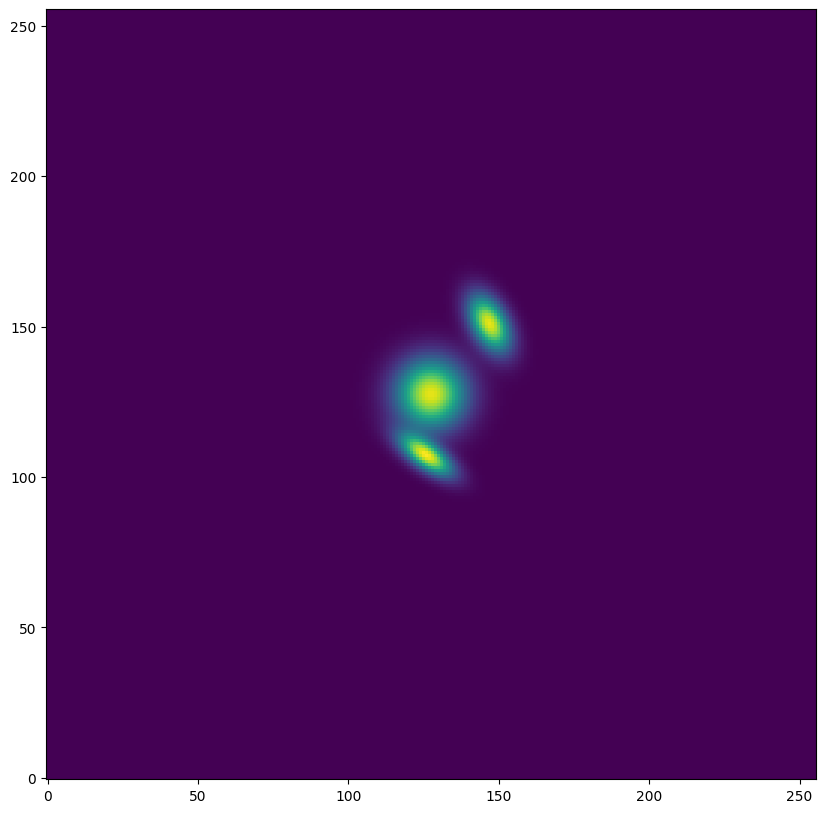

In [11]:
data_dir = 'test'
n_px = 256
n_chan = 1024
distance = 3.0 * U.Mpc
h = 0.7
vpeculiar = 0.0  * U.km / U.s
vsys = h * 100.0 * U.km * U.s**-1 * U.Mpc**-1 * distance
fwhm_x, fwhm_y = 8, 8
fwhm_z = 32
spatial_resolution = 0.1 
central_frequency = 250 * U.GHz
frequency_resolution = 10
hI_rest_frequency = 1420.4 * U.MHz
radio_hI_equivalence = U.doppler_radio(hI_rest_frequency)
central_velocity = central_frequency.to(U.km / U.s, equivalencies=radio_hI_equivalence)
velocity_resolution = 10
pa = 0
n_sources = 4
ra = 0 * U.deg
dec = 0 * U.deg

direction_vector = np.array(
            [
                np.cos(ra) * np.cos(dec),
                np.sin(ra) * np.cos(dec),
                np.sin(dec),
            ]
        )
distance_vector = direction_vector * distance
hubble_flow_vector = direction_vector * vsys
vpeculiar_vector = direction_vector * vpeculiar
print(hubble_flow_vector, vpeculiar_vector)
datacube = DataCube(
    n_px_x = n_px,
    n_px_y = n_px,
    n_channels = n_chan, 
    px_size = spatial_resolution * U.arcsec,
    channel_width = velocity_resolution * U.km / U.s,
    velocity_centre=vsys, 
    ra = ra,
    dec = dec,
    )
wcs = datacube.wcs

pos_x, pos_y, pos_z = wcs.sub(3).wcs_world2pix(ra, dec, vpeculiar, 0)
datacube = insert_gaussian(datacube, pos_x, pos_y, pos_z, fwhm_x, fwhm_y, fwhm_z, pa, n_px, n_chan)
n_companions = np.random.randint(0, n_sources)
n_companions = 2
sample_coords = sample_positions(pos_x, pos_y, pos_z, n_companions, 50, 50, 100, 10)
fwhm_xs = np.random.randint(2, 10, n_companions)
fwhm_ys = np.random.randint(2, 10, n_companions)
fwhm_zs = np.random.randint(2, 30, n_companions)
pas = np.random.randint(0, 360, n_companions)
for i, choords in tqdm(enumerate(sample_coords)):
    print(i, choords)
    datacube = insert_gaussian(datacube, choords[0], choords[1], choords[2], fwhm_xs[i], fwhm_ys[i], fwhm_zs[i], pas[i], n_px, n_chan)


print(datacube._array.shape)
plt.figure(figsize=(10, 10))
plt.imshow(np.sum(datacube._array[:, :, :, 0].value, axis=2), origin='lower')
plt.show()